# Photography studio image analysis for a single plant in side view (SV)

This Jupyter Notebook uses the PlantCV image analysis package to analyze images in a photo studio for the Journal of Video Education. This notebook can be open and run in a code-editing software, such as Visual Studio Code or Jupyter Lab. 

This notebook is used to process a sample image in order to view the steps and determine the optimal settings. After the settings are determined, convert this jupyter notebook into a python file for processing the entire set of images (see JoVE publication or the PlantCV website for instructions). You do not need to process each image individually here. 


PlantCV must be installed on the computer or server in which this notebook is being used, see instructions here in the Documentation: https://plantcv.readthedocs.io/en/latest/installation/

First, import the necessary package. If you get an error here, make sure your kernel (upper right) is set to PlantCV, and that you have PlantCV installed. 

In [1]:
# activate matplotlib, which will allow you to plot the images in the workflow
%matplotlib widget

# import plantcv
from plantcv import plantcv as pcv

# import the necessary tools to parallelize the workflow, which will allow you to next run all of the images in the set. 
from plantcv.parallel import WorkflowInputs
import os

Check your version of PlantCV to compare to this workflow. Update if needed according to the Documentation instructions. Here, our version is 4.4; this workflow will work with version 4.4 or later. 


In [2]:

pcv.__version__

'4.4'

## Import a test image and initialize settings ##

Take one image from your experiment (preferably a test image before you have captured all images) and import in order to determine your workflow settings and image quality. 

Define workflow inputs/outputs class to manage inputs in Jupyter where inputs are hardcoded for testing and workflow development. 
Choose 1 image for testing here. 

In [4]:
# Attributes:
#      images: (list, required): list of input images.
#      names: (str, required): string containing a comma-delimited list of keyword names for each input image.
#      result: (str, required): path/name for the output results file.
#      outdir: (str, required): path/name of the output directory.
#      writeimg: (bool, default = False): If True, images will be saved.
#      debug: (str, default = None): If None, debug is off. "plot" or "print" displays or saves intermediate images.

# Input/output options
args = WorkflowInputs(
    #replace with the file path of your input image
    images=["/Users/kmurphy/Library/CloudStorage/OneDrive-DDPSC/Murphy_Lab/writing/2024/2024-JoVE/github-upload/raw-images/Array-Pot_14_2024-07-19T09-21-12.jpg"],
    #here we are using the term "image" because this is a test workflow to optimize settings. You do not need to change it.
    names="image",
    #here we are using the term "test" because this is a test workflow to optimize settings. You do not need to change it.
    result="test.csv",
    #Using "." sets the directory to the current file path
    outdir=".",
    #Write the image to a file should default to False, so that not every test image is saved unless you want to save it. 
    writeimg=False,
    #Set debug to "plot" so that you can see the images as you are adjusting the settings in the workflow. 
    debug="plot",
     #here we are using the term "test" because this is a test workflow to optimize settings. You do not need to change it.
    sample_label="test"
    )


Set debug parameters. You can leave these settings or change to your preferred text size, etc. 

In [5]:
# Set debug to the global parameter that was specified in the above box
pcv.params.debug = args.debug

# Change display settings if needed to have a better view of the dpi, text size, or text thickness
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

# Import image
Read in your image, which is based on the path you put above in your input arguments. If you have changed your filename above, you do not need to change this code. 

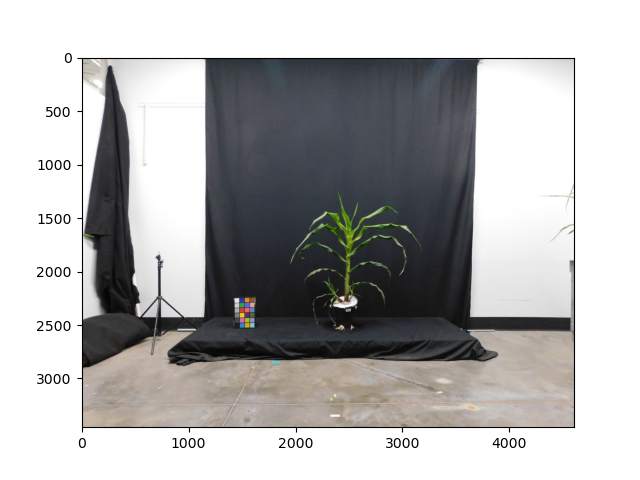

In [6]:
# Inputs:
#   filename - Image file to be read in (here we have specified "args.image" above for the filepath)
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv'. If your image is not "native" or you want to specify the image type, change the code below.

img, path, filename = pcv.readimage(filename=args.image, mode = 'native')


# Crop image if necessary
If your image goes outside the photo studio area like this one, crop your image to facilitiate easier analysis later. 
Note that cropping only works if your camera position is fixed relative to the object and background for your set of images. 
Always choose a new name, rather than write over what we defined as "img" above, it will help you with troubleshooting later. 
You will see a blue box overlayed onto your image, which is where the image will be cropped. If you do not like the cropping, adjust the numbers below. 

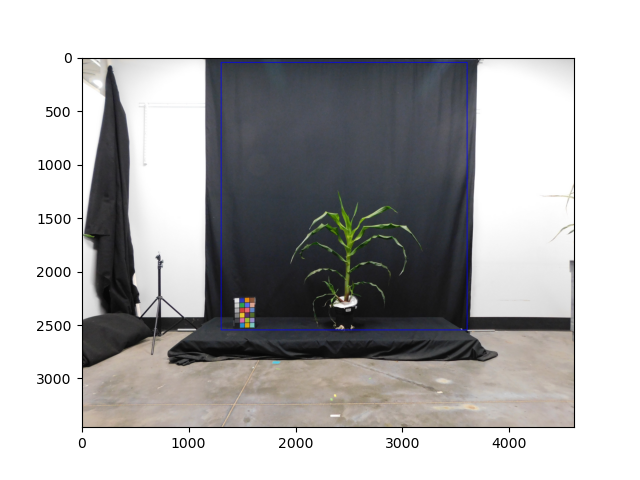

In [10]:
#   Parameters:
#          img - RGB, grayscale, or hyperspectral image data
#          x - Starting X coordinate
#          y - Starting Y coordinate
#          h - Height
#          w - Width
#   Context:
#        Crops image
#        Allows users to avoid splicing arrays with Python code, although Numpy arrays can be cropped with this method as well.

crop_img = pcv.crop(img=img, x=1300, y=50, h=2500, w=2300)


## Perform quality control for overexposure

Now that the image is imported and initially straightened, we will check the image quality, correct the color, and determine our necessary size conversion from pixels to cm. 

In order to check for over or under exposure of your image, run a quality control on a first test image. 
In this example, the color is acceptable because less than 5% of values are at the max (0) and minimum (255)
Run quality control after cropping, becasue it does not matter if the discarded regions are over or under exposed. 
If over or under exposed, change your camera settings. If you do not, color correction will discard color values because they are beyond the range of detection. 
This is not used in the workflow over all the images because it is a quality control for image capture. 

In [11]:
#   Parameters:
#          rgb_img (numpy.ndarray) - An image in BGR format as a 3D numpy array.
#          warning_threshold (float) - The percentage threshold for triggering a warning for over- or underexposure (default is 0.05 for 5%).
#   Context:
#        Used to check the image quality for under- or over-exposure.

pcv.qc.exposure(crop_img, warning_threshold=0.05)


alt.Chart(...)

alt.Chart(...)

# Rotate the image if necessary
If your image is not straight, rotate it without changing the dimensions of the image. 
In this example, the image is straight becasue our camera was on a flat surface, so we will rotate 0 degrees.

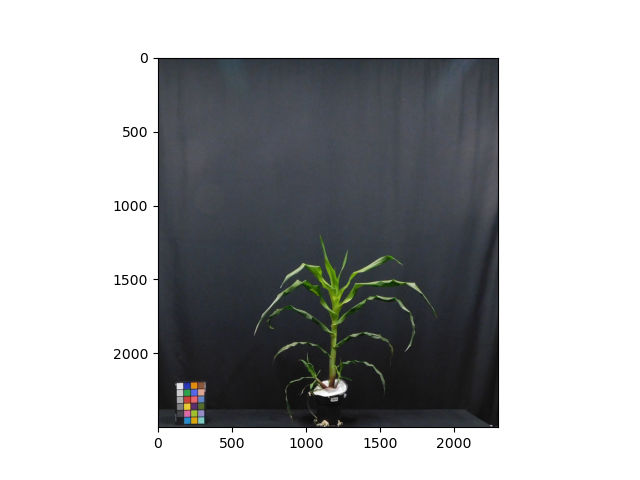

In [12]:
#    Parameters:
#        img - RGB or grayscale image data
#        rotation_deg - rotation angle in degrees, can be a negative number, positive values move counter clockwise.
#        crop - if crop is set to True, image will be cropped to original image dimensions, if set to False, the image size will be adjusted to accommodate new image dimensions.
#   Context:
#       Rotates image, sometimes it is necessary to rotate an image, especially when clustering objects.

rotate_img = pcv.transform.rotate(crop_img, 0, False)

# Color correction and size standardization
Next we will perform color correction and determine the conversion between pixels and cm units by using the color card as our size marker. 
transform.detect_color_card is one of the functions in the plantcv that automatically store data to the outputs class

First, detect the color card. If successful, the squares of the card will have circles on them. If needed, adjust the radius of the circles used to detect the card. 

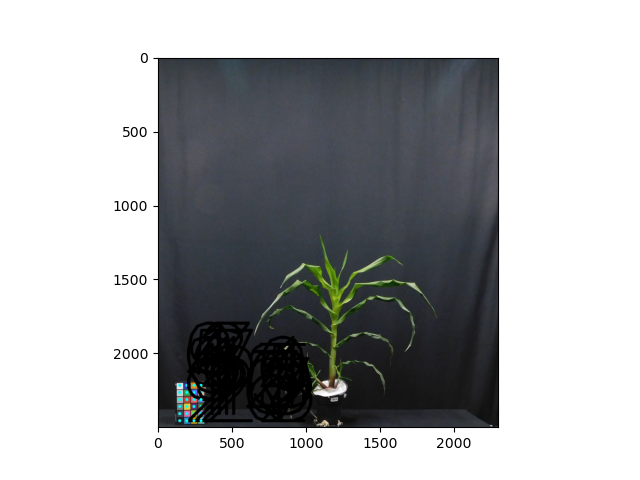

In [14]:
#     Parameters:
#          rgb_img - Input cropped RGB image data containing a color card.
#          label - Optional label parameter, modifies the variable name of observations recorded. (default = pcv.params.sample_label)
#          adaptive_method - Adaptive threhold method. 0 (mean) or 1 (Gaussian) (default = 1).
#          block_size - Size of a pixel neighborhood that is used to calculate a threshold value (default = 51). We suggest using 127 if using adaptive_method=0.
#          radius - Radius of circle to make the color card labeled mask (default = 20).
#          min_size - Minimum chip size for filtering objects after edge detection (default = 1000)
#     Returns:
#          labeled_mask - Labeled color card mask

card_mask = pcv.transform.detect_color_card(rgb_img=crop_img, radius=10, adaptive_method=1, block_size=101)

# Determine pixel to cm conversion for size standardization
Print average chip size, value is stored in outputs.observations. This will allow us to convert between units between pixels and cm. 
Here, our chip size is 4 cm, which this code tells us is equal to 43 pixels. We will use this conversion when performing data analysis on the extracted traits in R studio. 


In [15]:
pixel_units = pcv.outputs.observations['default']['median_color_chip_width']['value']

print(f"A color chip width is equivalent to {pixel_units} pixels. The conversion is X cm/{pixel_units} pixels, where X is the width of your color chip in cm (you should measure it, varies by manufacturer). ")
print(f"Your .csv file will have data in pixel units, you can convert using this information when you analyze the numerical data")


A color chip width is equivalent to 43.0 pixels. The conversion is X cm/43.0 pixels, where X is the width of your color chip in cm (you should measure it, varies by manufacturer). 
Your .csv file will have data in pixel units, you can convert using this information when you analyze the numerical data


Make a color card matrix, which is the current color values of the card you have detected. 

In [16]:
#   Parameters:
#       rgb_img - RGB image with color chips visualized, in this case 'rotate_img'
#       mask - a gray-scale img with unique values for each segmented space, representing unique, discrete color chips. card_mask created with pcv.transform.detect_color_card

#   Returns:
#      color_matrix - a n x 4 matrix containing the average red value, average green value, and average blue value for each color chip.
#      headers - a list of 4 headers corresponding to the 4 columns of color_matrix respectively

headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=rotate_img, mask=card_mask)

Define the standard color card matrix: we know what the colors of those chips should be in a "perfect" scenario based on the standard color cards available for purchase. 
We will correct to these known values. 
When using detect_color_card, you will set value for pos where white chip is present

In [17]:
#      Parameters:
#          pos - reference value indicating orientation of the color card. The reference is based on the position of the white chip:
#                pos = 0: bottom-left corner
#                pos = 1: bottom-right corner
#                pos = 2: top-right corner
#                pos = 3: top-left corner
#     Returns:
#          color_matrix - a n x 4 matrix containing the standard red, green, and blue values for each color chip

std_color_matrix = pcv.transform.std_color_matrix(pos=3)

Color correct your image to the standard values using the affine function. This will standardize the color of the image. 
Look at the resulting color corrected image (right) compared to the initial image (left), it should not appear to have abnormal colors. 
Abnormal coloring suggests the color card was damaged or not detected correctly, go back to the detection step and adjust the settings. 

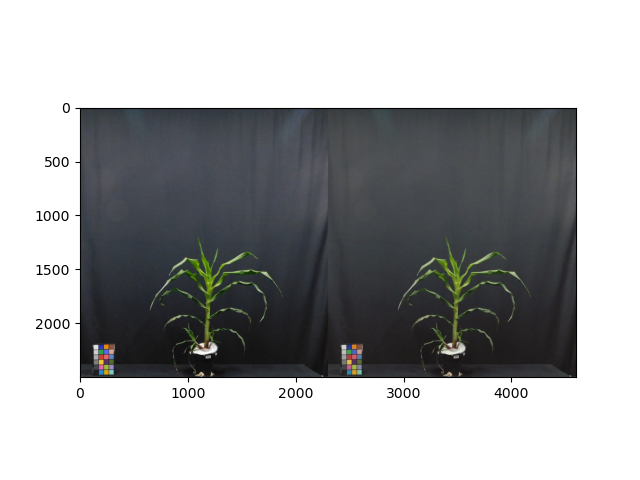

In [18]:
#        Parameters:
#             rgb_img - an RGB image with color chips visualized
#             source_matrix - array of RGB color values (intensity in the range [0-1]) from the image to be corrected where each row is one color reference and the columns are organized as index,R,G,B; created with plantcv.transform.get_color_matrix.
#             target_matrix - array of target RGB color values (intensity in the range [0-1]) where each row is one color reference and the columns are organized as index,R,G,B; created with plantcv.transform.std_color_matrix.

#        Returns:
#           img_cc - corrected image

img_cc = pcv.transform.affine_color_correction(rgb_img=rotate_img, source_matrix=card_matrix, 
                                               target_matrix=std_color_matrix)


Evaluate the necessary change in color to reach the standardized color profile. If the change in color is too drastic, you should evaluate whether the color card was properly detected (if the color changes to something very unlike what the "real" color looked like, the color card may be improperly detected). If the color change looks like the "real" color, but an extreme change, your image may be over or under exposed. Go back to the quality control for exposure above and adjust camera settings as needed. 

In the below example, our color change is close to linear, and our image looks appropriate to the true color, so we deem the images acceptable and proceed through the workflow. 

In [34]:
#      Parameters:
#          source_matrix - a 22x4 matrix containing the average red value, average green value, and average blue value for each color chip of the source image
#          target_matrix - a 22x4 matrix containing the average red value, average green value, and average blue value for each color chip of the target image
#          num_chips - the number of color card chips included in the matrices (integer)
#     Context: 
#           Use the get_color_matrix

pcv.transform.quick_color_check(source_matrix = card_matrix, target_matrix = std_color_matrix, num_chips = 24)

alt.Chart(...)

alt.Chart(...)

## Mask the plant in the image (i.e. segmentation or separation) ##
Now the image has been cropped, straightened, standardized for color, and the size marker values have been extracted. Next, we will "mask" the plant, the process of separating just the plant from the background and other objects in the image. 

Look at the colorspaces of this image. Determine which of these colorspaces is the "best" for masking, by finding the image where the image is most separate from the backgorund. 


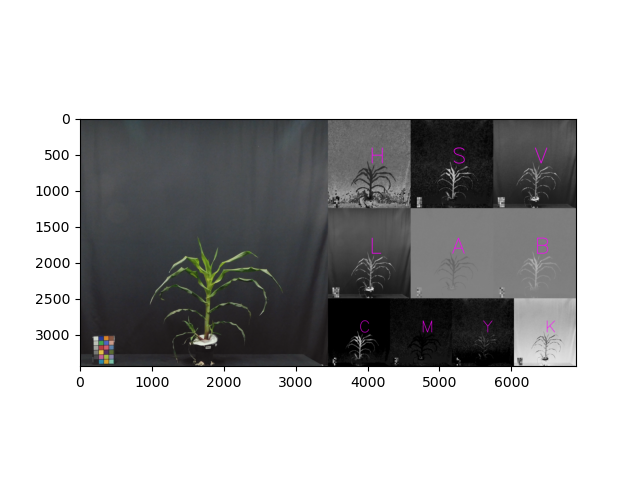

In [19]:
#    Parameters:
#        rgb_img - Corected RGB image data
#        original_img - Whether or not to include the original image as the debugging plot (default original_img=True)

#    Returns:
#        plotting_img - plotting all potential colorspaces from available PlantCV functions

colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc)

We will start by selecting the B channel because the plant appears distinct from the background. You may need to test multiple channels to determine which is most suitable for your application. 
We will convert our image to a binary image in the B channel

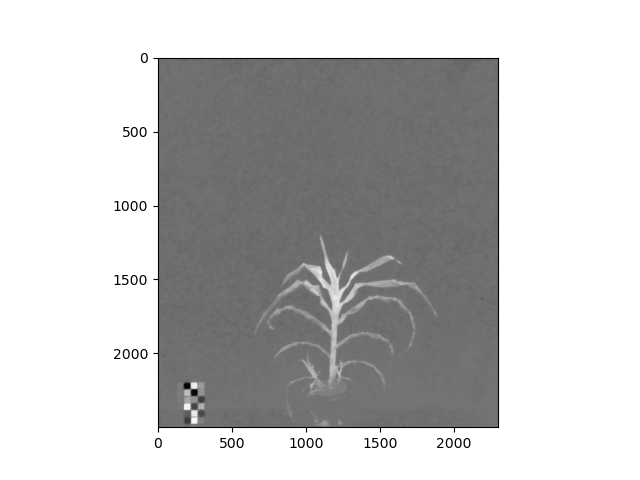

In [20]:
#  Parameters:
#      rgb_img - Corrected RGB image data
#       channel - Split 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
#   Context:
#       Used to help differentiate plant and background

#   Returns:
#       split image (l, a, or b channel)

b_img = pcv.rgb2gray_lab(rgb_img=img_cc, channel="b")


# Masking method: Single channel, binary threshold, OTSU
Next, we will "threshold" the image - this is choosing a value for the binary image - pixels above or below a specified threshold are selected. 
You may choose a value or instead use otsu, which will automatically choose a value. Note that otsu is not suitable for every application, but it is the recommended method to start. 



In [ ]:
#   Parameters:
#      gray_img - Grayscale image data
#      object_type - "light" or "dark" (default: "light"). If object is lighter than the background then standard thresholding is done. If object is darker than the background then inverse thresholding is done.
#   Context:
#      Used to help differentiate plant and background

#   Returns:
#      thresholded/binary image

b_thresh_otsu = pcv.threshold.otsu(b_img, object_type="light")

# Masking method: Single channel, binary threshold, manual
If you do not have good separation of plant from background using otsu, use a binary threshold method such as the one below. To choose the threshold, hover your mouse over the image in the previous cell and observe the values. Choose a threshold value that will contain the plant but not the background. 

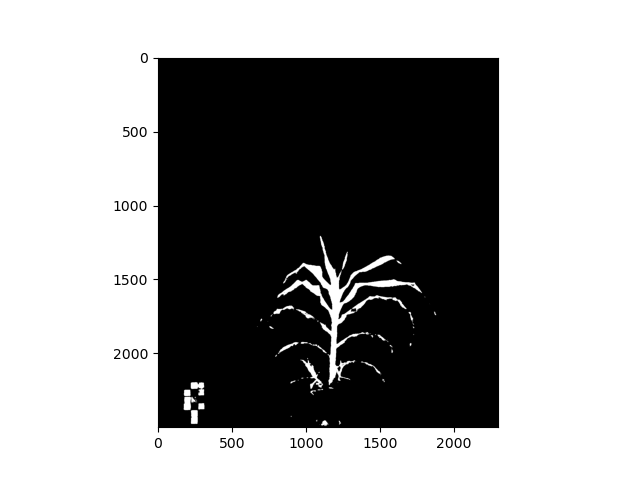

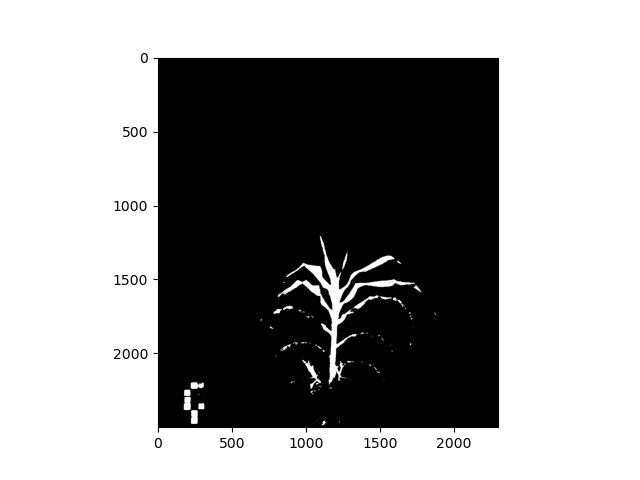

In [21]:
#     Parameters:
#          gray_img - Grayscale image data
#          threshold - Threshold value (0-255)
#          object_type - "light" or "dark" (default: "light"). If object is lighter than the background then standard thresholding is done. If object is darker than the background then inverse thresholding is done.

#     Returns:
#         thresholded/binary image
b_thresh_manual = pcv.threshold.binary(gray_img=b_img, threshold=145, object_type="light")


# Masking method: Dual channel, binary threshold, manual
If you do not have successful an individual channel using the otsu or selected threshold value method above, test out the other channels. If you have tested all of the channels, you may need to use a dual channel method. 

To use the dual channel method, first save a temporary image of the color corrected image that will be used for plotting the color scatter. 

In [22]:
#  Parameters:
#       img- image object
#       filename- desired name of image file, supported extensions are PNG, JPG, and TIFF
#   Context:
#       Often used to debug new image processing workflows
#       Used to write out final results images

pcv.print_image(img_cc, filename = "./img_cc_temp.png")

Plot the color scatter for two channels - choose two channels based on the colorspaces above that will provide the best segmentation. You may try different colorspaces. Each point in the color scatter represents a pixel in the image, and its X and Y value (the two chosen colorspaces). The pixel is colored to represent the actual color. 

This plot is just for troubleshooting and will not be used in the workflow on all images. 

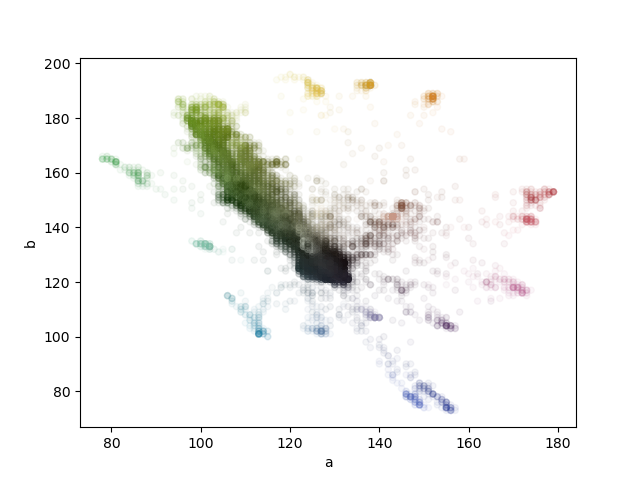

In [23]:
#    Parameters:
#          paths_to_imgs - List of paths to the images.
#          x_channel - Channel to use for the horizontal coordinate of the scatter plot. Options: 'R', 'G', 'B', 'l', 'a', 'b', 'h', 's', 'v', 'gray', and 'index'.
#          y_channel - Channel to use for the vertical coordinate of the scatter plot. Options: 'R', 'G', 'B', 'l', 'a', 'b', 'h', 's', 'v', 'gray', and 'index'.
#   Context:
#        The aim of this visualization is to help selecting the threshold parameters to segment an image or dataset of images.This visualization can show the pixels in several images at once, making the selected value more likely to be valid for the whole dataset.

#   Returns:
#         fig, ax

color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./img_cc_temp.png"] , x_channel = "a", y_channel ="b" )

Evaluate the color scatter plot. Select two points that would connect and keep the pixels above (or below if above = False) the line. This allows for thresholding on two channels at one time. 
For example, green pixels are the plant in this scenario, and are wanted to keep, so we place the line below the green pixels. 

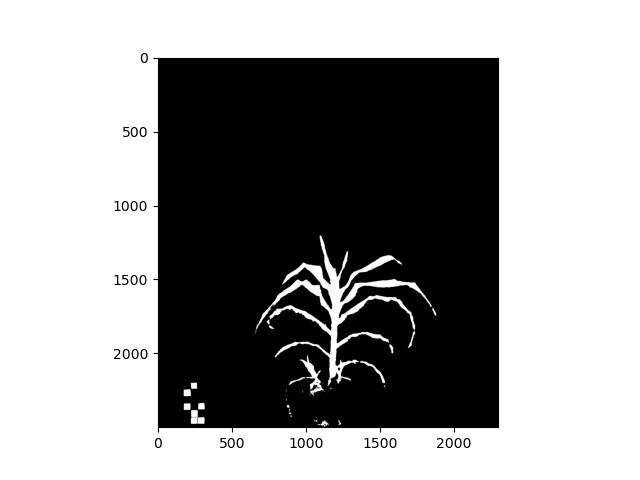

In [24]:
#    Parameters:
#         rgb_img - Corrected RGB image
#         x_channel - Channel to use for the horizontal coordinate. Options: 'R', 'G', 'B', 'l', 'a', 'b', 'h', 's', 'v', 'gray', and 'index'
#         y_channel - Channel to use for the vertical coordinate. Options: 'R', 'G', 'B', 'l', 'a', 'b', 'h', 's', 'v', 'gray', and 'index'
#         points - List containing two points as tuples defining the segmenting straight line
#         above - Whether the pixels above the line are given the value of 0 or 255
#   Returns:
#        thresholded/binary image

dual_thresh = pcv.threshold.dual_channels(rgb_img = img_cc, x_channel = "a", y_channel = "b", points = [(80,80),(125,138)], above=True)

# Clean the mask
Now that our plant is successfully separated from the background of the image, we will clean the mask to reduce noise. 

Fill in small objects that are not your plant, such as dirt, stray pixels, etc. Change the fill size if needed to fill smaller or bigger portions.

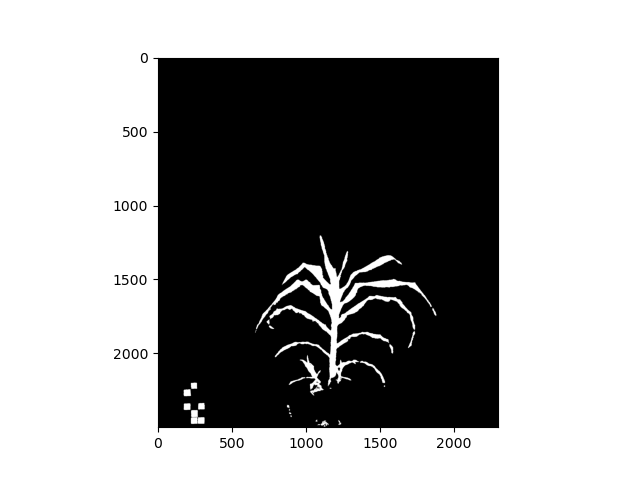

In [25]:
#     Parameters:
#           bin_img - Binary image data
#           size - minimum object area size in pixels (integer), smaller objects will be filled
#      Context:
#           Used to reduce image noise
#      Returns:
#           fill_image

fill_mask = pcv.fill(bin_img=dual_thresh, size=50)


If there are pixels in the plant that are not selected and should be, use the fill holes function to fill in holes in the leaf. 


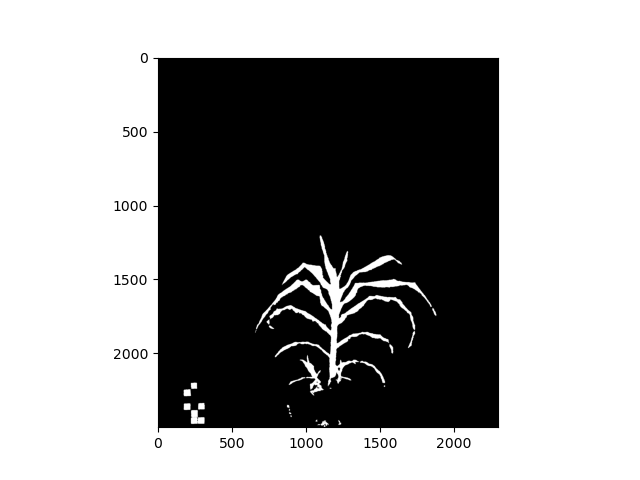

In [26]:
#     Parameters:
#          gray_img - Grayscale or binary image data
#          kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None, use cross-shaped structuring element.
#     Context:
#          Used to reduce image noise, specifically small dark spots (i.e. "pepper").
#     Returns:
#        filtered_img

mask_fill_holes = pcv.closing(gray_img=fill_mask)

Remove noise from the edge of the object using the erode function. Increase the ksize or i to remove more. If no removal is necessary, skip this step. This was not needed for this example, so the code is commented so as to not be used. 

In [27]:
#    Parameters:
#        gray_img - Grayscale (usually binary) image data
#        ksize - Kernel size, an odd integer that is used to build a ksize x ksize matrix using np.ones. Must be greater than 1 to have an effect
#        i - An integer for number of iterations, i.e. the number of consecutive filtering passes
#    Context:
#       Used to perform morphological erosion filtering. Helps remove isolated noise pixels or remove boundary of objects.
#    Returns:
#        image after erosion


# mask_erode = pcv.erode(gray_img=mask_fill_holes, ksize=3, i=1)

Define the region of interest (ROI) that contains your plant. This should include your plant, but not you color card or other objects

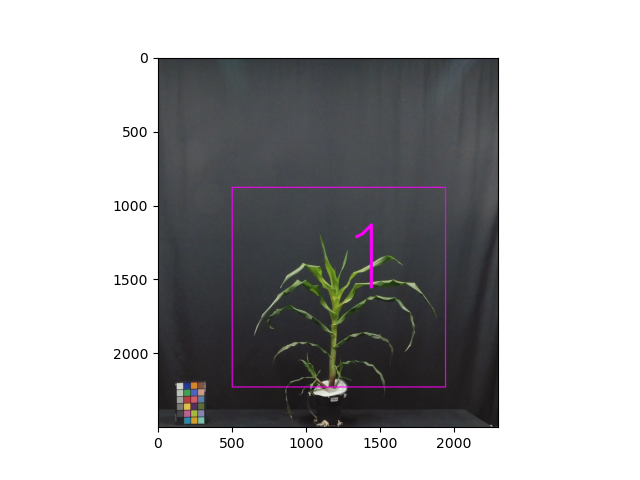

In [28]:
#       Parameters:
#             img - Corrected RGB or grayscale image to plot the ROI on in debug mode.
#             x - The x-coordinate of the upper left corner of the rectangle.
#             y - The y-coordinate of the upper left corner of the rectangle.
#            h - The height of the rectangle.
#            w - The width of the rectangle.
#      Context:
#          Used to define a region of interest in the image.
#      Returns:
#         roi - region of interest

roi1 = pcv.roi.rectangle(img=img_cc, x=500, y=880, h=1350, w=1440)

Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI. We have set to partial here so that if a leaf extends outside of your ROI it will still be selected; anything touching the object in the ROI will be selected even if it is outside the ROI. 

Switch to "cutto" if you have other plants that are getting selected on accident, and you will "cut" anything outside of the ROI. 

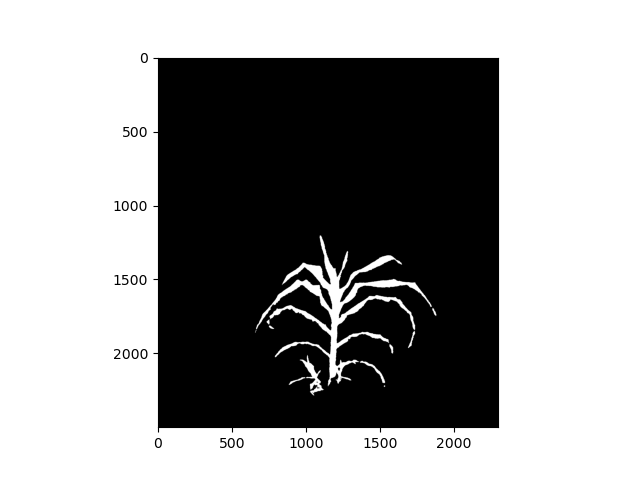

In [29]:
#       Parameters:
#            mask = binary image data to be filtered
#            roi = region of interest, an instance of the Objects class, output from one of the pcv.roi
#            roi_type = 'partial' (for partially inside, default), 'cutto', or 'largest' (keep only the largest contour)
#      Context:
#           Used to filter objects within a region of interest and decide which ones to keep.
#      Warning:
#           Using roi_type='largest' will only keep the largest outer connected region of non-zero pixels.
#      Returns:
#           filtered_mask

roi_mask  = pcv.roi.filter(mask=mask_fill_holes, roi=roi1, roi_type='partial')


# Analyze Shape Traits
Now you should have a clean mask of just your plant, not other noise or objects selected in the image. If this is not the case, go back and adjust the settings until you do have a clean mask of just your plant. If you still do not have a clean mask, additional image cleaning methods are available in the PlantCV Documentation. 

If you have multiple plants to analyze in an image, see tutorials available in the PlantCV Documentation. 

The printed image below should show your plant with a blue outline on the edge of the plant (representing leaf area) and a pink line around the outer convex hull of the plant. If these lines inclue other objects in the image and not just the plant, there is noise in the mask. Go back and clean the mask further. 

Output traits include single-value-traits, such as area (aka leaf area), height, width, and more. 

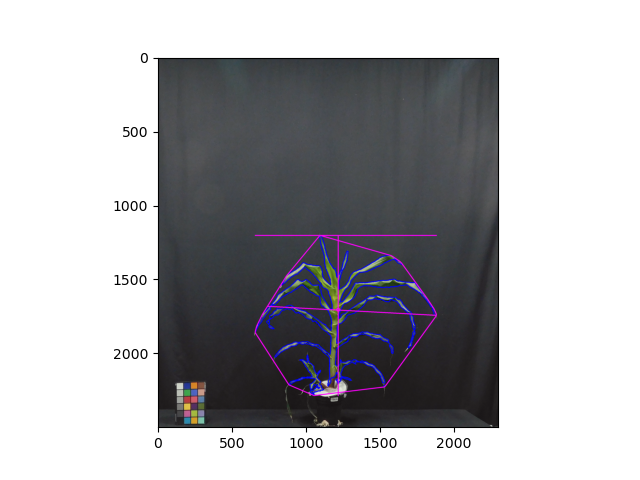

In [30]:
#    Parameters:
#        img - Corrected RGB or grayscale image data for plotting.
#        labeled_mask - Labeled mask of objects (32-bit, output from pcv.roi.filter).
#        n_labels - Total number expected individual objects (default = 1).
#        label - Optional label parameter, modifies the variable name of observations recorded. Can be a prefix or list (default = pcv.params.sample_label).
#    Context:
#         Used to output size and shape characteristics of individual objects (labeled regions).
#    Returns:
#         analysis_image

shape_image = pcv.analyze.size(img=img_cc, labeled_mask=roi_mask)


While analyze.size function provides many useful measurements, it does not detect the edge of the pot to get an accurate measure of plant height relative to the soil line in the pot. Instead, also use the analze.bound_horizontal function below to determine the shape traits relative to above and below a defined line. This is useful if your plant is hanging below the pot and you want height from the top of the pot.

Set your line_position by finding the x-value at the top of the pot, hover your cursor over the images above to get the proper value. 
Output traits include single-value-traits, such as area (aka leaf area), height, width, and more, all relative to the boundary line and labeled "above" or "below" bound. 

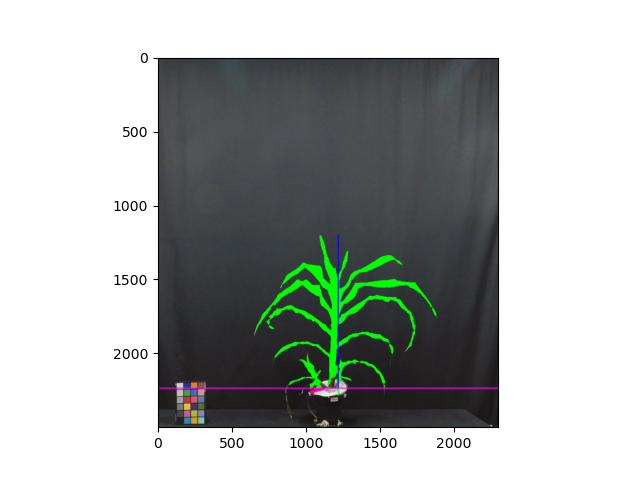

In [31]:
# 

#        Parameters:
#             img - Corrected RGB or grayscale image data for plotting
#             labeled_mask - Labeled mask of objects (32-bit).
#             line_position - position of boundary line (a value of 0 would draw the line through the top of the image)
#             n_labels - Total number expected individual objects (default = 1).
#             label - Optional label parameter, modifies the variable name of observations recorded. Can be a prefix or list (default = pcv.params.sample_label).

#       Returns:
#           image with boundary data

shape_bound_image = pcv.analyze.bound_horizontal(img=img_cc,labeled_mask=roi_mask, 
                                               line_position=2241, label="default")


# Analyze color traits
Output traits include single-value-traits that are means (such as mean hue circular mean), as well as multi-value-traits that are histograms of the color values of each pixel. 

In [32]:

#     Parameters:
#          rgb_img - Corrected RGB image data
#          labeled_mask - Labeled mask of objects (32-bit, output from pcv.roi.filter).
#          n_labels - Total number expected individual objects (default = 1).
#          colorspaces - 'all', 'rgb', 'lab', or 'hsv'. This can limit the data saved out (default = 'hsv').
#          label - Optional label parameter, modifies the variable name of observations recorded. Can be a prefix or list (default = pcv.params.sample_label).

#     Context:
#         Used to extract color data from RGB, LAB, and HSV color channels.
#         Generates histogram of color channel data.
#     Returns:
#         Ridgeline plot of histograms of hue values
color_histogram = pcv.analyze.color(rgb_img=img_cc, labeled_mask=roi_mask, colorspaces='all', label="default")



alt.FacetChart(...)

# Save the results
The save results function will take the measurements stored when running any PlantCV analysis functions, format, and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 

This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one). 
Inspect the outputs file to ensure it contains measurements. If it does not, go back and test the analysis functions to ensure you are getting a resulting image with the outlines of the plant. 


In [33]:
pcv.outputs.save_results(filename=args.result)

# Next, save the analysis images for inspection if desired. 
pcv.print_image(shape_image, os.path.join(args.outdir, filename + "_shape.jpg"))
pcv.print_image(shape_bound_image, os.path.join(args.outdir, filename + "_shape-bound.jpg"))



# Convert the workflow to allow for high-throughput analysis of a set of images. 

Now that the workflow has successfully processed a sample image, it's time to run it "in paralell" over the entire set of images. To do so, follow the following steps. Files can be found in the GitHub repository containing this notebook file, associated with the JoVE article. 

1. Open the file "workflow.py" in a code editor. Edit with any parameters changed in this notebook. Save the file. 
2. Open the file "photo-studio-SV-config.json" and edit the file paths as noted in the file to the appropriate folder of input images, output image folder, name of the results file, etc. 
3. Open a terminal and run the following code: 
conda activate plantcv

4. Next in the terminal, change the path to the correct file path of "photo-studio-SV-config.json" and run:
plantcv-run-workflow --config /Users/kmurphy/photo-studio-SV-config.json

5. Inspect the output images to determine if the code was appropriate for all images. If not, return to this notebook and continue optimizing the workflow. If suitable, move on. 
6. Next in the terminal, change the  path to the correct file path of "results-photo-studio.json" and desired path of "/Users/kmurphy/results-photo-studio.csv" and run:
plantcv-utils json2csv -j /Users/kmurphy/results-photo-studio.json -c /Users/kmurphy/results-photo-studio.csv   

7. Perform statistical analyses of the output .csv file. We recommend using the pcvr package in R Studio for statistical analysis, as it is specifically formulated to manage PlantCV results.  